In [1]:
import os,sys,string, time
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from particle import Particle

import Utilities.Functions as Functions
import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
from Utilities.ipython_exit import exit

print ('Success')


Success


# Purpose
This script is for looking at the kinematics of the HNL daughters.

It uses the weighted HNL decay files which only have truth information on the HNL decays.

# Reading in .pkl files

In [3]:
Run = "run1" #Only run1 files produced for these weighted truth files

if Run == "run1": horn_curr = "fhc"
else: print("Only run1 files produced for these weighted truth files!")

load_lepton_signal = False
load_pi0_signal = True

Majorana = False

if Majorana == True: HNL_type = "majorana"
elif Majorana == False: HNL_type = "dirac"
else: print("Majorana variable needs to be True or False!")

FLATTEN = False #Mostly put as False

print(f"Loading {Run} files")

loc_pkls = f"../new_scalings/negwt_fix/"

signal_samples_dict = {}

HNL_masses = [10, 20, 50, 100, 150]

variables = "*"

if load_lepton_signal == True:
    dec_type = "ee"
    for HNL_mass in HNL_masses:
        uproot_file = uproot3.open(loc_pkls+f"{HNL_mass}MeV_ee_ONLY_fhc_{HNL_type}_negwt_fix.root")["generator/event_tree"]
        df_signal = uproot_file.pandas.df(variables, flatten=FLATTEN)
        signal_samples_dict[HNL_mass] = df_signal
        print(f"{HNL_mass}MeV Signal is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")
    
if load_pi0_signal == True:
    pi0_signal_samples_dict = {}
    dec_type = "pi0"
    # loc_pkls = f"../new_scalings/negwt_fix/"
    loc_pkls = f"../new_scalings/weinberg_fix/"
    if HNL_type == "majorana": HNL_type_name = "majorana_fixed"
    if HNL_type == "dirac": HNL_type_name = "dirac"
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        # uproot_file = uproot3.open(loc_pkls+f"{HNL_mass}MeV_pi0_fhc_majorana_fixed.root")["generator/event_tree"]
        # uproot_file = uproot3.open(loc_pkls+f"{HNL_mass}MeV_pi0_fhc_{HNL_type}_negwt_fix.root")["generator/event_tree"]
        uproot_file = uproot3.open(loc_pkls+f"{HNL_mass}MeV_pi0_fhc_{HNL_type_name}.root")["generator/event_tree"]
        df_signal = uproot_file.pandas.df(variables, flatten=FLATTEN)
        signal_samples_dict[HNL_mass] = df_signal
        print(f"{HNL_mass}MeV pi0 signal is "+str(len(signal_samples_dict[HNL_mass]))+" entries long.")
        
print(f"Successfully loaded {Run} {dec_type} {HNL_type} weighted files")


Loading run1 files
150MeV pi0 signal is 50000 entries long.
180MeV pi0 signal is 49950 entries long.
200MeV pi0 signal is 49700 entries long.
220MeV pi0 signal is 49550 entries long.
240MeV pi0 signal is 49800 entries long.
245MeV pi0 signal is 49600 entries long.
Successfully loaded run1 pi0 dirac weighted files


In [4]:
print(signal_samples_dict[150].keys())

filtered_index_dict = {}
for HNL_mass in signal_samples_dict:
    filtered_index_dict[HNL_mass] = signal_samples_dict[HNL_mass].index

Index(['kaon_mom_x', 'kaon_mom_y', 'kaon_mom_z', 'kaon_energy', 'kaon_decay_x',
       'kaon_decay_y', 'kaon_decay_z', 'kaon_decay_t', 'hnl_mom_x',
       'hnl_mom_y', 'hnl_mom_z', 'hnl_energy', 'hnl_decay_x', 'hnl_decay_y',
       'hnl_decay_z', 'hnl_decay_t', 'daughter1_mom_x', 'daughter1_mom_y',
       'daughter1_mom_z', 'daughter1_energy', 'daughter2_mom_x',
       'daughter2_mom_y', 'daughter2_mom_z', 'daughter2_energy', 'weight',
       'flux_weight', 'decay_weight', 'branching_ratio_weight', 'selected',
       'kaon_pdg', 'daughter1_pdg', 'daughter2_pdg'],
      dtype='object')


## Creating new variables

In [5]:
av_HNL_direction = [0.324,0.738,-0.591]

def Make_new_variables(df, entries=[]): #For unflattened dfs
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    # Num_evs = len(df)
    mc_p_magnitude = []
    mc_px_sum, mc_py_sum, mc_pz_sum = [], [], []
    mc_E_leading, mc_E_sub, mc_E_asymmetry = [], [], []
    mc_cos_opening_angle, mc_opening_angle = [], []
    
    # for i in range(Num_evs):
    for i in entries_it:
        mc_p1 = np.sqrt(df['daughter1_mom_x'][i]**2+df['daughter1_mom_y'][i]**2+df['daughter1_mom_z'][i]**2)
        mc_p2 = np.sqrt(df['daughter2_mom_x'][i]**2+df['daughter2_mom_y'][i]**2+df['daughter2_mom_z'][i]**2)
        mc_p_magnitude.append(np.array([mc_p1,mc_p2]))
        mc_px_sum.append(df['daughter1_mom_x'][i]+df['daughter2_mom_x'][i])
        mc_py_sum.append(df['daughter1_mom_y'][i]+df['daughter2_mom_y'][i])
        mc_pz_sum.append(df['daughter1_mom_z'][i]+df['daughter2_mom_z'][i])
        E_leading = max(np.array([df['daughter1_energy'][i],df['daughter2_energy'][i]]))
        E_sub = min(np.array([df['daughter1_energy'][i],df['daughter2_energy'][i]]))
        mc_E_leading.append(E_leading)
        mc_E_sub.append(E_sub)
        mc_E_asymmetry.append(E_sub / E_leading)
        
        dot_product = (df['daughter1_mom_x'][i]*df['daughter2_mom_x'][i] + df['daughter1_mom_y'][i]*df['daughter2_mom_y'][i] + df['daughter1_mom_z'][i]*df['daughter2_mom_z'][i])
        magnitude_dot_product = mc_p1*mc_p2
        mc_cos_opening_angle.append(dot_product/magnitude_dot_product)
        mc_opening_angle.append(np.arccos(dot_product/magnitude_dot_product))
        
        
    df2 = df.copy()
    df2["mc_px_sum"], df2["mc_py_sum"], df2["mc_pz_sum"] = np.array(mc_px_sum), np.array(mc_py_sum), np.array(mc_pz_sum)
    df2["mc_p_magnitude"] = mc_p_magnitude
    df2["mc_E_leading"], df2["mc_E_sub"] = np.array(mc_E_leading), np.array(mc_E_sub)
    df2["mc_E_asymmetry"] = np.array(mc_E_asymmetry)
    df2["mc_cos_opening_angle"] = np.array(mc_cos_opening_angle)
    df2["mc_opening_angle"] = np.array(mc_opening_angle)
   
    return df2

def Make_angle_wrt(df, vector, entries=[]):
    """
    Vector should be a unit vector, for the desired direction. 
    """
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    # Num_evs = len(df)
    
    polar_angle = []
    # for i in range(Num_evs):
    for i in entries_it:
        direction = vector[0]*df["mc_px_sum"][i] + vector[1]*df["mc_py_sum"][i] + vector[2]*df["mc_pz_sum"][i] # a dot b
        p_sum = np.sqrt(df["mc_px_sum"][i]**2+df["mc_py_sum"][i]**2+df["mc_pz_sum"][i]**2) # magnitude b
        polar_angle.append(np.arccos(direction/p_sum))
        
    df2 = df.copy()
    df2["mc_polar_angle"] = np.array(polar_angle)
    
    return df2

def Make_daughter_angle_wrt(df, vector, entries=[]):
    """
    Vector should be a unit vector, for the desired direction. 
    """
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    # Num_evs = len(df)
    
    polar_angle_1 = []
    polar_angle_2 = []
    # for i in range(Num_evs):
    for i in entries_it:
        direction_1 = vector[0]*df['daughter1_mom_x'][i] + vector[1]*df['daughter1_mom_y'][i] + vector[2]*df['daughter1_mom_z'][i] # a dot b
        p_sum_1 = np.sqrt(df['daughter1_mom_x'][i]**2+df['daughter1_mom_y'][i]**2+df['daughter1_mom_z'][i]**2) # magnitude b
        
        direction_2 = vector[0]*df['daughter2_mom_x'][i] + vector[1]*df['daughter2_mom_y'][i] + vector[2]*df['daughter2_mom_z'][i] # a dot b
        p_sum_2 = np.sqrt(df['daughter2_mom_x'][i]**2+df['daughter2_mom_y'][i]**2+df['daughter2_mom_z'][i]**2) # magnitude b
        
        polar_angle_1.append(np.arccos(direction_1/p_sum_1))
        polar_angle_2.append(np.arccos(direction_2/p_sum_2))
        
    df2 = df.copy()
    df2["mc_daughter1_polar_angle"] = np.array(polar_angle_1)
    df2["mc_daughter2_polar_angle"] = np.array(polar_angle_2)
    
    return df2

def Make_single_new_variables(df, rest_mass, entries=[]):
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    
    mc_p_magnitude = []
    mc_E_kinetic = []
    for i in entries_it:
        mc_p = np.sqrt(df['daughter1_mom_x'][i]**2+df['daughter1_mom_y'][i]**2+df['daughter1_mom_z'][i]**2)
        mc_E = df['daughter1_energy'][i] - rest_mass
        
        mc_p_magnitude.append(mc_p)
        mc_E_kinetic.append(mc_E)
        
    df2 = df.copy()
    df2["mc_p_magnitude"] = mc_p_magnitude
    df2["mc_E_kinetic"] = mc_E_kinetic
    
    return df2

def Make_single_angle(df, vector, entries=[]):
    """
    Vector should be a unit vector, for the desired direction. 
    """
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    # Num_evs = len(df)
    
    polar_angle = []
    # for i in range(Num_evs):
    for i in entries_it:
        direction = vector[0]*df["mc_px"][i] + vector[1]*df["mc_py"][i] + vector[2]*df["mc_pz"][i]
        p_sum = np.sqrt(df["mc_px"][i]+df["mc_py"][i]+df["mc_pz"][i])
        polar_angle.append(np.arccos(direction/p_sum))
        
    df2 = df.copy()
    df2["mc_polar_angle_single"] = np.array(polar_angle)
    
    return df2

def Make_single_angle_file(df, vector, entries=[]):
    """
    Vector should be a unit vector, for the desired direction. 
    """
    if isinstance(entries,list): 
        Num_evs = len(df)
        entries_it = np.arange(0, Num_evs,1)
    else: entries_it = entries
    # Num_evs = len(df)
    
    polar_angle = []
    # for i in range(Num_evs):
    for i in entries_it:
        direction = vector[0]*df['daughter1_mom_x'][i] + vector[1]*df['daughter1_mom_y'][i] + vector[2]*df['daughter1_mom_z'][i]
        p_sum = np.sqrt(df['daughter1_mom_x'][i]+df['daughter1_mom_y'][i]+df['daughter1_mom_z'][i])
        polar_angle.append(np.arccos(direction/p_sum))
        
    df2 = df.copy()
    df2["mc_polar_angle_single"] = np.array(polar_angle)
    
    return df2


In [6]:
if load_lepton_signal == True:
    for HNL_mass in signal_samples_dict:
        signal_samples_dict[HNL_mass]=Make_new_variables(signal_samples_dict[HNL_mass], filtered_index_dict[HNL_mass])
        print(f"Done {HNL_mass}MeV")
    print("Done")

    direction = av_HNL_direction

    for HNL_mass in signal_samples_dict:
        signal_samples_dict[HNL_mass]=Make_angle_wrt(signal_samples_dict[HNL_mass], direction, [])
        signal_samples_dict[HNL_mass]=Make_daughter_angle_wrt(signal_samples_dict[HNL_mass], direction, [])

        print(f"Done {HNL_mass}MeV")


In [7]:
direction = av_HNL_direction
pi0_mass = 0.135 #GeV

if load_pi0_signal == True:
    for HNL_mass in signal_samples_dict:
        signal_samples_dict[HNL_mass]=Make_single_new_variables(signal_samples_dict[HNL_mass], pi0_mass, entries=signal_samples_dict[HNL_mass].index)
        signal_samples_dict[HNL_mass]=Make_single_angle_file(signal_samples_dict[HNL_mass], direction, signal_samples_dict[HNL_mass].index)
        print(f"Done {HNL_mass}")

/tmp/ipykernel_11144/3458455142.py:152: RuntimeWarning: invalid value encountered in sqrt
  p_sum = np.sqrt(df['daughter1_mom_x'][i]+df['daughter1_mom_y'][i]+df['daughter1_mom_z'][i])
/tmp/ipykernel_11144/3458455142.py:153: RuntimeWarning: invalid value encountered in arccos
  polar_angle.append(np.arccos(direction/p_sum))


Done 150


/tmp/ipykernel_11144/3458455142.py:152: RuntimeWarning: invalid value encountered in sqrt
  p_sum = np.sqrt(df['daughter1_mom_x'][i]+df['daughter1_mom_y'][i]+df['daughter1_mom_z'][i])
/tmp/ipykernel_11144/3458455142.py:153: RuntimeWarning: invalid value encountered in arccos
  polar_angle.append(np.arccos(direction/p_sum))


Done 180


/tmp/ipykernel_11144/3458455142.py:152: RuntimeWarning: invalid value encountered in sqrt
  p_sum = np.sqrt(df['daughter1_mom_x'][i]+df['daughter1_mom_y'][i]+df['daughter1_mom_z'][i])
/tmp/ipykernel_11144/3458455142.py:153: RuntimeWarning: invalid value encountered in arccos
  polar_angle.append(np.arccos(direction/p_sum))


Done 200


/tmp/ipykernel_11144/3458455142.py:153: RuntimeWarning: invalid value encountered in arccos
  polar_angle.append(np.arccos(direction/p_sum))
/tmp/ipykernel_11144/3458455142.py:152: RuntimeWarning: invalid value encountered in sqrt
  p_sum = np.sqrt(df['daughter1_mom_x'][i]+df['daughter1_mom_y'][i]+df['daughter1_mom_z'][i])


Done 220


/tmp/ipykernel_11144/3458455142.py:153: RuntimeWarning: invalid value encountered in arccos
  polar_angle.append(np.arccos(direction/p_sum))
/tmp/ipykernel_11144/3458455142.py:152: RuntimeWarning: invalid value encountered in sqrt
  p_sum = np.sqrt(df['daughter1_mom_x'][i]+df['daughter1_mom_y'][i]+df['daughter1_mom_z'][i])


Done 240


/tmp/ipykernel_11144/3458455142.py:152: RuntimeWarning: invalid value encountered in sqrt
  p_sum = np.sqrt(df['daughter1_mom_x'][i]+df['daughter1_mom_y'][i]+df['daughter1_mom_z'][i])
/tmp/ipykernel_11144/3458455142.py:153: RuntimeWarning: invalid value encountered in arccos
  polar_angle.append(np.arccos(direction/p_sum))


Done 245


# Functions

In [8]:
def Plot_variable_signal(variable, HNL_samples_dict=[], xlabel=[], xlims=[0,0], ylims=[], bins=40, figsize=[10,10], dpi=100, MergeBins=False, 
                         density=True,legloc="best",logy = False, cutline = None, savefig=False, filename=None, plot_entries=False,
                         fraction=False, legsize=18):
    
    if(HNL_samples_dict==[]): raise Exception("Specify samples dict") 
    if(xlabel==[]): xlabel=variable
    if logy == True: logscale="log"
    elif logy == False: logscale="linear"
    
    fig,ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=figsize, dpi=dpi)
    
    for HNL_mass in HNL_samples_dict:
    
        #var_HNL=HNL_samples_dict[HNL_mass][variable] #old way when specifying variable
        var_HNL=HNL_samples_dict[HNL_mass]
        Num_entries = len(var_HNL)
       
        if xlims[0] == 0 and xlims[1] == 0: xlims = [min(var_HNL),max(var_HNL)]
    
        if(isinstance(bins, int)):
            nbins=bins
            bins=np.linspace(xlims[0],xlims[1],nbins+1)
        else: nbins=len(bins)-1
               
        if plot_entries==True: label=[f"{HNL_mass} MeV HNL: " + str(Num_entries) + " entries"]
        if plot_entries==False: label=[f"{HNL_mass} MeV HNL"]
            
        if fraction == False:
            plt.hist(var_HNL,
    #               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
                  label=label,
                  range=xlims,bins=bins,
                  stacked=False,density=density,
                  histtype="step",lw=3)
        if fraction == True:
            plt.hist(var_HNL,weights=np.ones(len(var_HNL)) / len(var_HNL),
                     label=label,
                  range=xlims,bins=bins,
                  stacked=False,density=False,
                  histtype="step",lw=3)
    
    if(isinstance(cutline, (int,float))):
        plt.axvline(x=cutline, lw=3, color='green', linestyle = 'dashed')
    
    if(logy == True):
        plt.yscale("log")
    else:
        plt.yscale("linear")
        
    if(density == True):
        plt.ylabel("Fraction of total events")
    
    plt.legend(loc=legloc,frameon=True,fontsize=legsize)
    
    plt.xlabel(xlabel)
    plt.xlim(xlims)
    if ylims!=[]:
        plt.ylim(ylims)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.yscale(logscale)
    if filename == None:
        Name = variable + "_" + Run + "_" + logscale
    else:
        Name = filename
    if savefig == True:
        plt.savefig("plots/Truth_studies/Signal_plots/" + Name + ".png")
        plt.savefig("plots/Truth_studies/Signal_plots/" + Name + ".pdf")

In [9]:
def check_variable(df,variable,debug=True): #The df should NOT be flattened. Will return a series which can be plotted. 
    first_entry = df.index[0]
    if isinstance(df[variable][first_entry], (np.ndarray)):
        if(debug):print("This variable has an array of entries per event.")
        Num_events = len(df[variable])
        if(debug):print("The total number of events is " + str(Num_events))
        copy_column = df[variable].copy()
        exploded = copy_column.explode(variable)
        Num_nans = exploded.isna().sum()
        if(debug):print("The number of events with empty arrays is " + str(Num_nans))
        if(debug):print("Fraction of non-empty arrays is " + str(1-(Num_nans/Num_events)))
        Nans_removed = exploded.dropna()
        Num_entries = len(Nans_removed)
        if(debug):print("The total number of entries is " + str(Num_entries))
        
        return Nans_removed, Num_entries
    if isinstance(df[variable][first_entry], (int,float,np.int32,np.float32,np.uint32,np.nan)):
        if(debug):print("This variable has one entry per event.")
        Num_events = len(df[variable])
        if(debug):print("The total number of events is " + str(Num_events))
        copy_column = df[variable].copy()
        Num_nans = copy_column.isna().sum()
        if Num_nans != 0:
            if(debug):print("There are " + str(Num_nans) + " Nan values, removing now")
            copy_column.dropna()
        Num_entries = len(copy_column)
        return copy_column, Num_entries
    else: print("Not sure what type this variable is!")
    
def remove_non_reco_vals(df,debug=True): #Feed in the output of the check_variable
    #value = -1e15
    value = -9998
    first_entry = df.index[0]
    if(debug):print("Total number of entries is " + str(len(df)))
    if(debug):print("Number of very negative values is " + str(len(df.loc[df < value])))

    if(len(df.loc[df < value]) > 0):
        new_df = df.drop(df.loc[df < value].index) #Removes values entirely
        if(debug):print("New number of entries is " + str(len(new_df)))
            # if(len(df.loc[df == -1.0]) > 0):
            #     df.loc[(df == -1.0), variable] = new_value #Sets the new value
            # if(len(df.loc[df == np.nan]) > 0):
            #     df.loc[(df == np.nan), variable] = new_value #Sets the new value
            # if(len(df.loc[df == np.inf]) > 0):
            #     df.loc[(df == np.inf), variable] = new_value #Sets the new value
    else: new_df = df.copy()
    return new_df, len(new_df)

def Get_av_hnl_momentum(df):
    """
    Returns a vector of the mean momenta of the parent HNL
    """
    x_sum = df['hnl_mom_x'].sum()
    y_sum = df['hnl_mom_y'].sum()
    z_sum = df['hnl_mom_z'].sum()
    
    x_av = x_sum/len(df)
    y_av = y_sum/len(df)
    z_av = z_sum/len(df)
    
    direction = []
    for i in df.index:
        mc_p = np.sqrt(df['hnl_mom_x'][i]**2+df['hnl_mom_y'][i]**2+df['hnl_mom_z'][i]**2)
        direction.append([df['hnl_mom_x'][i]/mc_p, df['hnl_mom_y'][i]/mc_p, df['hnl_mom_z'][i]/mc_p])
    
    return [x_av, y_av, z_av], direction

def Get_av_daughter_momentum(df, daughter=1):
    """
    Returns a vector of the mean momenta of the parent HNL
    """
    x_sum = df[f'daughter{daughter}_mom_x'].sum()
    y_sum = df[f'daughter{daughter}_mom_y'].sum()
    z_sum = df[f'daughter{daughter}_mom_z'].sum()
    
    x_av = x_sum/len(df)
    y_av = y_sum/len(df)
    z_av = z_sum/len(df)
    
    direction = []
    for i in df.index:
        mc_p = np.sqrt(df[f'daughter{daughter}_mom_x'][i]**2+df[f'daughter{daughter}_mom_y'][i]**2+df[f'daughter{daughter}_mom_z'][i]**2)
        direction.append([df[f'daughter{daughter}_mom_x'][i]/mc_p, df[f'daughter{daughter}_mom_y'][i]/mc_p, df[f'daughter{daughter}_mom_z'][i]/mc_p])
    
    return [x_av, y_av, z_av], direction

def Get_av_direction(direction_list):
    sum_x, sum_y, sum_z = 0, 0, 0
    for i, direction in enumerate(direction_list):
        sum_x += direction[0]
        sum_y += direction[1]
        sum_z += direction[2]
    av_x  = sum_x/(len(direction_list))
    av_y  = sum_y/(len(direction_list))
    av_z  = sum_z/(len(direction_list))
    
    return [av_x, av_y, av_z]

## Parent HNL momentum

In [ ]:
test_av_dict, directions_dict = {}, {}
daughter_av_dict, daughter_directions_dict = {}, {}
daughter2_av_dict, daughter2_directions_dict = {}, {}
for HNL_mass in signal_samples_dict:
    test_av_dict[HNL_mass], directions_dict[HNL_mass] = Get_av_hnl_momentum(signal_samples_dict[HNL_mass])
    daughter_av_dict[HNL_mass], daughter_directions_dict[HNL_mass] = Get_av_daughter_momentum(signal_samples_dict[HNL_mass], daughter=1)
    daughter2_av_dict[HNL_mass], daughter2_directions_dict[HNL_mass] = Get_av_daughter_momentum(signal_samples_dict[HNL_mass], daughter=2)
    print(f"Done {HNL_mass}")
# print(test_av)


In [ ]:
av_dir_dict = {}
av_daughter_dict, av_daughter2_dict = {}, {}
for HNL_mass in signal_samples_dict:
    av_dir_dict[HNL_mass] = Get_av_direction(directions_dict[HNL_mass])
    av_daughter_dict[HNL_mass] = Get_av_direction(daughter_directions_dict[HNL_mass])
    av_daughter2_dict[HNL_mass] = Get_av_direction(daughter2_directions_dict[HNL_mass])

In [ ]:
print(av_dir_dict)
print(av_daughter_dict)
print(av_daughter2_dict)

In [ ]:
print(av_HNL_direction)
#[0.324,0.738,-0.591]

## Plotting

In [10]:
Plot_only_lepton = load_lepton_signal #Final state is e+e-
Plot_only_pi0 = load_pi0_signal #Final state is pi0

# if Plot_only_lepton == True: sample_dict = signal_samples_dict
# elif Plot_only_pi0 == True: sample_dict = signal_samples_dict

print_vals = input("Do you want to print all the variables in the sample? y/n ")
if print_vals == "y":
    var_list = []
    for var in signal_samples_dict[150].keys():
        var_list.append(var)
    print(var_list)
else:
    print("Not printing variables.")

Do you want to print all the variables in the sample? y/n  y


['kaon_mom_x', 'kaon_mom_y', 'kaon_mom_z', 'kaon_energy', 'kaon_decay_x', 'kaon_decay_y', 'kaon_decay_z', 'kaon_decay_t', 'hnl_mom_x', 'hnl_mom_y', 'hnl_mom_z', 'hnl_energy', 'hnl_decay_x', 'hnl_decay_y', 'hnl_decay_z', 'hnl_decay_t', 'daughter1_mom_x', 'daughter1_mom_y', 'daughter1_mom_z', 'daughter1_energy', 'daughter2_mom_x', 'daughter2_mom_y', 'daughter2_mom_z', 'daughter2_energy', 'weight', 'flux_weight', 'decay_weight', 'branching_ratio_weight', 'selected', 'kaon_pdg', 'daughter1_pdg', 'daughter2_pdg', 'mc_p_magnitude', 'mc_E_kinetic', 'mc_polar_angle_single']


In [11]:
variable_names_dict = {'mc_px_sum':"Sum of x-momenta [GeV]", 'mc_py_sum':"Sum of y-momenta [GeV]", 'mc_pz_sum':"Sum of z-momenta [GeV]",
                       'mc_p_magnitude':"Magnitude of lepton momenta [GeV]", 'mc_E_leading':"Leading lepton energy [GeV]",
                       'mc_E':"Energy [GeV]", 'mc_px':"Momentum in x-direction [GeV]", 'mc_py':"Momentum in y-direction [GeV]",
                       'mc_pz':"Momentum in z-direction [GeV]", 'mc_p_magnitude':"Momentum [GeV]", 'mc_E_kinetic':"Kinetic energy [GeV]",
       'mc_E_sub':"Sub-leading lepton energy [GeV]", 'mc_E_asymmetry':"Energy asymmetry", 'mc_cos_opening_angle':"cosine(opening angle)",
       'mc_opening_angle':"Opening angle [radians]", 'mc_polar_angle':"Angle w.r.t parent HNL [radians]",
                       "mc_polar_angle_single":"Angle w.r.t parent HNL [radians]", 'mc_daughter1_polar_angle':"Daughter 1 angle w.r.t parent HNL [radians]",
                      'mc_daughter2_polar_angle':"Daughter 2 angle w.r.t parent HNL [radians]"}

In [12]:
thesis_plots_ee = ['mc_E_leading', 'mc_E_sub', 'mc_E_asymmetry', 'mc_pz_sum', 'mc_opening_angle', 'mc_polar_angle']
thesis_plots_pi0 = ["mc_polar_angle_single", 'mc_p_magnitude']

xlims_dict = {'mc_E_leading':[0,0.25],
              'mc_E_sub':[0,0.15],
              'mc_E_asymmetry':[0.0,1.0],
              'mc_pz_sum':[-0.2, 0.1],
              'mc_opening_angle':[0.0, 3.2],
              'mc_polar_angle':[0.0, 1.5],
              'mc_p_magnitude':[0.0, 0.25],
              'mc_polar_angle_single':[0.0, 2.0]}

logy_dict = {'mc_E_leading':False,
              'mc_E_sub':False,
              'mc_E_asymmetry':False,
              'mc_pz_sum':False,
              'mc_opening_angle':True,
              'mc_polar_angle':True,
              'mc_p_magnitude':False,
              'mc_polar_angle_single':False}

ylims_dict = {'mc_E_leading':[],
              'mc_E_sub':[],
              'mc_E_asymmetry':[],
              'mc_pz_sum':[],
              'mc_opening_angle':[1e-3,1.0],
              'mc_polar_angle':[1e-3,1.0],
              'mc_p_magnitude':[],
              'mc_polar_angle_single':[]}


Do you want to save these figures? y/n  n


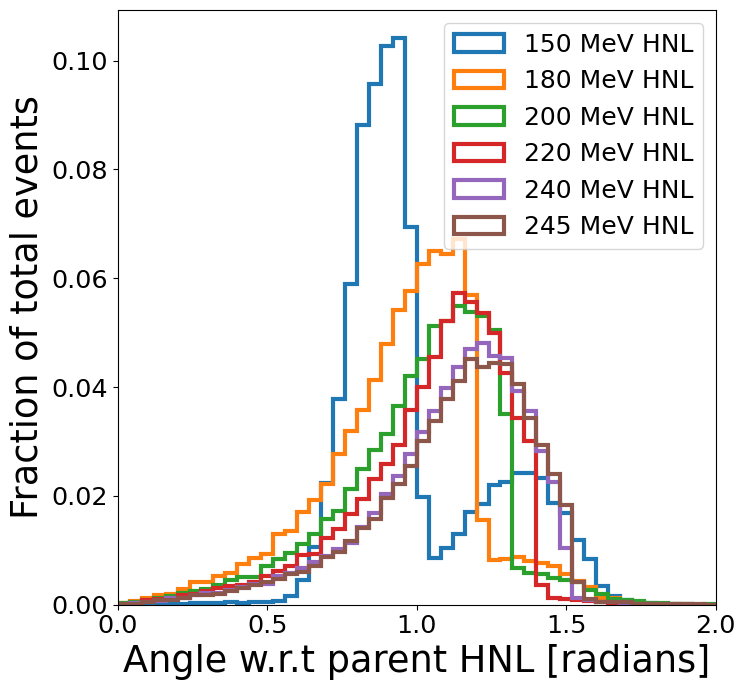

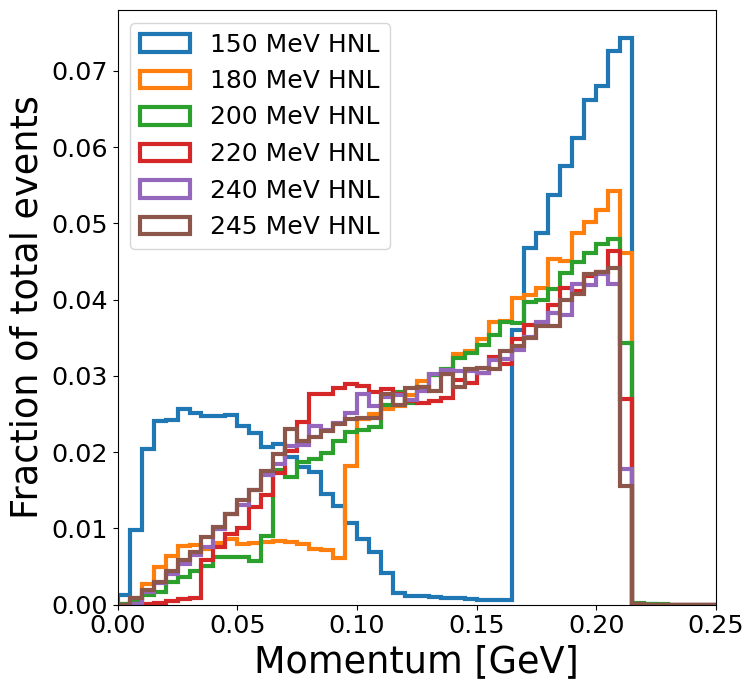

In [13]:
debug = False
plot_dict = {}
Num_entries_dict = {}

save_figures = input("Do you want to save these figures? y/n ")

if save_figures == "y": savefig = True
else: savefig = False

if Plot_only_lepton == True: var_list = thesis_plots_ee
if Plot_only_pi0 == True: var_list = thesis_plots_pi0

for var in var_list:
    plot_dict = {}
    Num_entries_dict = {}
    # for sample in plot_samples:
    for sample in signal_samples_dict.keys():
        # print(f"Mass is {sample} MeV")
        plot_dict[sample], Num_entries_dict[sample] = check_variable(signal_samples_dict[sample],var,debug=debug)
        plot_dict[sample], Num_entries_dict[sample] = remove_non_reco_vals(plot_dict[sample],debug=debug)

    Plot_variable_signal(var, HNL_samples_dict=plot_dict, xlabel=variable_names_dict[var], 
                         xlims=xlims_dict[var], ylims=ylims_dict[var], bins=50, 
                         figsize=[8,8], dpi=100, MergeBins=False, density=True,legloc="best",logy = logy_dict[var],
                         cutline = None, savefig=savefig, filename = f"{dec_type}/{var}_{HNL_type}_{Run}",fraction=True, legsize=18)
    

## Old code for working out daugher pdgs etc.

In [ ]:
eleven = Particle.from_pdgid(11)
twelve = Particle.from_pdgid(12)
thirteen = Particle.from_pdgid(13)
fourteen = Particle.from_pdgid(14)
one_one_one = Particle.from_pdgid(111)

print("eleven is " + str(eleven))
print("twelve is " + str(twelve))
print("thirteen is " + str(thirteen))
print("fourteen is " + str(fourteen))
print(one_one_one)


In [ ]:
FLATTEN = True

flat_samples_dict = {}

#Loading files for filtering ee events
if load_lepton_signal == True:
    for HNL_mass in HNL_masses:
        uproot_file = uproot3.open(loc_pkls+f"{HNL_mass}MeV_ee_ONLY_fhc_majorana_negwt_fix.root")["generator/event_tree"]
        df_signal = uproot_file.pandas.df(variables, flatten=FLATTEN)
        flat_samples_dict[HNL_mass] = df_signal
        print(f"FLAT {HNL_mass}MeV Signal is "+str(len(flat_samples_dict[HNL_mass]))+" entries long.")
    
if load_pi0_signal == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        # uproot_file = uproot3.open(loc_pkls+f"{HNL_mass}MeV_pi0_fhc_majorana_fixed.root")["generator/event_tree"]
        uproot_file = uproot3.open(loc_pkls+f"{HNL_mass}MeV_pi0_fhc_majorana_negwt_fix.root")["generator/event_tree"]
        df_signal = uproot_file.pandas.df(variables, flatten=FLATTEN)
        flat_samples_dict[HNL_mass] = df_signal
        print(f"FLAT {HNL_mass}MeV Signal is "+str(len(flat_samples_dict[HNL_mass]))+" entries long.")
        

In [ ]:
for HNL_mass in flat_samples_dict:
    signal_samples_dict[HNL_mass]["rse_id"] = signal_samples_dict[HNL_mass].index.values
    flat_samples_dict[HNL_mass]["rse_id"] = flat_samples_dict[HNL_mass].index.values

## Remove e, mu, nu events

In [ ]:
#Make rse_id
# for HNL_mass in signal_samples_dict:
#     signal_samples_dict[HNL_mass] = Functions.make_unique_ev_id(signal_samples_dict[HNL_mass])
#     flat_samples_dict[HNL_mass] = Functions.make_unique_ev_id(flat_samples_dict[HNL_mass])


In [ ]:
flat_samples_dict[150]["daughter2_pdg"].head(20)

In [ ]:
flat_samples_dict[150]["daughter1_pdg"].head(20)

In [ ]:
#need pdgs of minus 11 and 11. 
e_e_evs = {}
mu_e_evs = {}
mu_plus_e_evs = {}
mu_mu_evs = {}
mu_nu_mu_bar_evs = {}
electrons_dict = {}
positrons_dict = {}

pi0_dict = {}
nu_dict = {}
nu_pi0_evs = {}

if load_lepton_signal == True:
    for HNL_mass in signal_samples_dict:
        print(f"Original length is of {HNL_mass}MeV " + str(len(flat_samples_dict[HNL_mass])))
        positron = flat_samples_dict[HNL_mass].query("daughter1_pdg==-11")
        elec = flat_samples_dict[HNL_mass].query("daughter2_pdg==11")
        
        mu = flat_samples_dict[HNL_mass].query("daughter2_pdg==13")
        mu_bar = flat_samples_dict[HNL_mass].query("daughter1_pdg==-13 or daughter2_pdg==-13")
        nu_mu_bar = flat_samples_dict[HNL_mass].query("daughter1_pdg==-14")

        e_e = Functions.make_common_evs_df([elec, positron])
        mu_e = Functions.make_common_evs_df([positron, mu])
        mu_plus_e = Functions.make_common_evs_df([mu_bar, elec])
        mu_mu = Functions.make_common_evs_df([mu, mu_bar])
        mu_nu_mu_bar = Functions.make_common_evs_df([mu_bar, nu_mu_bar])
        # mu_mu = Functions.make_common_evs_df([mu, mu_bar, nu_mu_bar])
        
        e_e_evs[HNL_mass]=e_e
        mu_e_evs[HNL_mass]=mu_e
        mu_plus_e_evs[HNL_mass]=mu_plus_e
        mu_mu_evs[HNL_mass]=mu_mu
        mu_nu_mu_bar_evs[HNL_mass]=mu_nu_mu_bar
        # print("Num ee decays is " + str(len(common_evs[HNL_mass])*2))
    
if load_pi0_signal == True: 
    for HNL_mass in signal_samples_dict:
        print(f"Original length is of FLAT {HNL_mass}MeV " + str(len(flat_samples_dict[HNL_mass])))
        print(f"Original length is of {HNL_mass}MeV " + str(len(signal_samples_dict[HNL_mass])))
        pi0 = flat_samples_dict[HNL_mass].query("daughter1_pdg==111")
        nu = flat_samples_dict[HNL_mass].query("daughter2_pdg==-12 or daughter2_pdg==12")
        
        positron = flat_samples_dict[HNL_mass].query("daughter1_pdg==-11")
        elec = flat_samples_dict[HNL_mass].query("daughter2_pdg==11") 
        
        mu = flat_samples_dict[HNL_mass].query("daughter2_pdg==13")
        mu_bar = flat_samples_dict[HNL_mass].query("daughter1_pdg==-13 or daughter2_pdg==-13")
        
        pi0_dict[HNL_mass] = pi0
        nu_dict[HNL_mass] = nu

        e_e = Functions.make_common_evs_df([elec, positron])
        common = Functions.make_common_evs_df([pi0, nu])
        e_mu = Functions.make_common_evs_df([positron, mu])
        mu_mu = Functions.make_common_evs_df([mu, mu_bar])
        nu_pi0_evs[HNL_mass]=common
        e_e_evs[HNL_mass]=e_e
        mu_e_evs[HNL_mass] = e_mu
        mu_mu_evs[HNL_mass] = mu_mu

        print("Num pi0 decays is " + str(len(nu_pi0_evs[HNL_mass])))

In [ ]:
frac_ee, frac_mumu, frac_emu = {}, {}, {}
frac_all_mus, frac_all_emus = {}, {}
if load_lepton_signal == True:
    for HNL_mass in signal_samples_dict:
        frac_ee[HNL_mass] = len(e_e_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_mumu[HNL_mass] = len(mu_mu_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_emu[HNL_mass] = len(mu_e_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_all_emus[HNL_mass] = (len(mu_e_evs[HNL_mass])+len(mu_plus_e_evs[HNL_mass]))/len(signal_samples_dict[HNL_mass])
        frac_all_mus[HNL_mass] = (len(mu_mu_evs[HNL_mass])+len(mu_nu_mu_bar_evs[HNL_mass]))/len(signal_samples_dict[HNL_mass])
        
        print(f"{HNL_mass} emu frac is " + str(frac_all_emus[HNL_mass]))

frac_nu_pi0 = {}
frac_nu_pi0_plus_emu = {}
frac_nu_pi0_emu_ee = {}
if load_pi0_signal == True:
    for HNL_mass in signal_samples_dict:
        frac_nu_pi0[HNL_mass] = len(nu_pi0_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_ee[HNL_mass] = len(e_e_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_emu[HNL_mass] = len(mu_e_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_mumu[HNL_mass] = len(mu_mu_evs[HNL_mass])/len(signal_samples_dict[HNL_mass])
        frac_nu_pi0_plus_emu[HNL_mass] = (len(nu_pi0_evs[HNL_mass]) + len(mu_e_evs[HNL_mass]))/len(signal_samples_dict[HNL_mass])
        frac_nu_pi0_emu_ee[HNL_mass] = (len(nu_pi0_evs[HNL_mass]) + len(mu_e_evs[HNL_mass]) + len(e_e_evs[HNL_mass]))/len(signal_samples_dict[HNL_mass])
        print(f"{HNL_mass} nu pi0 frac is " + str(frac_nu_pi0[HNL_mass]))

In [ ]:
if load_lepton_signal == True:
    e_mu_plus_ee, mu_mu_plus_others = {}, {}
    for HNL_mass in signal_samples_dict:
        e_mu_plus_ee[HNL_mass] =  frac_ee[HNL_mass]+frac_all_emus[HNL_mass]
        
# if load_pi0_signal == True:
#     nu_pi0_plus_others = {}
#     for HNL_mass in signal_samples_dict:
#         nu_pi0_plus_others[HNL_mass] = 

In [ ]:
if load_lepton_signal == True:
    x_int_list = range(0, len(frac_ee.keys()))
    plt.bar(x_int_list, frac_ee.values(), label=r"$\nu e^{+}e^{-}$", tick_label=list(frac_ee.keys()))
    plt.bar(x_int_list, frac_all_emus.values(), label=r"$\nu e\mu$", tick_label=list(frac_ee.keys()), bottom=list(frac_ee.values()))
    plt.bar(x_int_list, frac_all_mus.values(), label=r"$\nu \mu\mu$", tick_label=list(frac_ee.keys()),bottom=list(e_mu_plus_ee.values()))

    plt.axhline(1.0,ls="--", color="black")
    plt.ylabel("Fraction of events")
    plt.xlabel("HNL mass [MeV]")
    plt.xlim(-0.5, 13)
    plt.legend(fontsize=22, loc="center right")
    plt.tight_layout()

    plt.savefig("plots/Generator/channel_fractions_negwt_fix.pdf")

In [ ]:
if load_pi0_signal == True:
    x_int_list = range(0, len(frac_nu_pi0.keys()))
    plt.bar(x_int_list, frac_nu_pi0.values(), label=r"$\nu \pi^{0}$", tick_label=list(frac_nu_pi0.keys()))
    plt.bar(x_int_list, frac_emu.values(), label=r"$\nu e\mu$", tick_label=list(frac_ee.keys()), bottom=list(frac_nu_pi0.values()))
    plt.bar(x_int_list, frac_ee.values(), label=r"$\nu e^{+}e^{-}$", tick_label=list(frac_ee.keys()), bottom=list(frac_nu_pi0_plus_emu.values()))
    plt.bar(x_int_list, frac_mumu.values(), label=r"$\mu \mu$", tick_label=list(frac_ee.keys()), bottom=list(frac_nu_pi0_emu_ee.values()))

    plt.axhline(1.0,ls="--", color="black")
    plt.ylabel("Fraction of events")
    plt.xlabel("HNL mass [MeV]")
    plt.xlim(-0.5, 13)
    plt.legend(fontsize=22, loc="center right")
    plt.tight_layout()

    plt.savefig("plots/Generator/channel_fractions_pi0_dirac_scaling_samples.pdf")

In [ ]:
e_e_evs[HNL_mass]["rse_id"].head()

In [ ]:
print(len(e_e_evs[150]))

In [ ]:
filtered_dict, filtered_out_dict = {}, {}

if load_lepton_signal == True:
    for HNL_mass in signal_samples_dict:
        filtered_dict[HNL_mass] = signal_samples_dict[HNL_mass].loc[(signal_samples_dict[HNL_mass]['rse_id'].isin(e_e_evs[HNL_mass]['rse_id']))]
        filtered_out_dict[HNL_mass] = signal_samples_dict[HNL_mass].loc[(~signal_samples_dict[HNL_mass]['rse_id'].isin(e_e_evs[HNL_mass]['rse_id']))]
    
if load_pi0_signal == True:
    for HNL_mass in signal_samples_dict:
        filtered_dict[HNL_mass] = flat_samples_dict[HNL_mass].loc[(flat_samples_dict[HNL_mass]['rse_id'].isin(nu_pi0_evs[HNL_mass]['rse_id']))]
        filtered_out_dict[HNL_mass] = flat_samples_dict[HNL_mass].loc[(~flat_samples_dict[HNL_mass]['rse_id'].isin(nu_pi0_evs[HNL_mass]['rse_id']))]
    
print(len(filtered_out_dict[150]))

In [ ]:
filtered_index_dict = {}
for HNL_mass in signal_samples_dict:
    filtered_index_dict[HNL_mass] = filtered_dict[HNL_mass].index


In [ ]:
Num_evs = len(signal_samples_dict[150])
print(Num_evs)
entries = np.arange(0, Num_evs,1)
print(entries)

In [ ]:
# Plot_variable_signal(var, HNL_samples_dict=plot_dict, xlabel=[], xlims=[0.01,0.5], bins=40, 
#                      figsize=[10,10], dpi=100, MergeBins=False, density=True,legloc="best",logy = False, cutline = None, savefig=False)

Plot_variable_signal(var, HNL_samples_dict=plot_dict, xlabel=variable_names_dict[var], xlims=[0,0.25], ylims=[],bins=50, 
                     figsize=[8,8], dpi=100, MergeBins=False, density=True,legloc="best",logy = False,
                     cutline = None, savefig=True, filename = f"ee_majorana_{var}_{Run}",fraction=True)


In [ ]:
Plot_variable_signal(var_2, HNL_samples_dict=plot_dict_2, xlabel=variable_names_dict[var_2], xlims=[0,0.15], ylims=[], bins=50, 
                     figsize=[8,8], dpi=100, MergeBins=False, density=True,legloc="best",logy = False,
                     cutline = None, savefig=False, filename = f"ee_majorana_{var_2}_{Run}",fraction=True)

In [ ]:
# if load_pi0_signal == True:
Plot_variable_signal(var_3, HNL_samples_dict=plot_dict_3, xlabel=variable_names_dict[var_3], xlims=[0,1.0],ylims=[], bins=50, 
                 figsize=[8,8], dpi=100, MergeBins=False, density=True,legloc="upper right",logy = False,
                 cutline = None, savefig=False, filename = f"ee_majorana_{var_3}_{Run}",fraction=True)

In [ ]:
sample_dict[2]['mc_polar_angle']